#Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
# import rea
from tensorflow import keras
import operator
import warnings
warnings.filterwarnings('ignore')
pd.set_option('expand_frame_repr', False)

In [ ]:
!pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 25.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.7
    Uninstalling Werkzeug-2.3.7:
      Successfully uninstalled Werkzeug-2.3.7


In [ ]:
!pip install dash-bootstrap-components
# pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 4.4 MB/s eta 0:00:00


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import dash_bootstrap_components as dbc  # pip install dash-bootstrap-components
import plotly.express as px              # pip install plotly
import pandas as pd                      # pip install pandas
from datetime import date
import datetime      # pip install wordcloud
import plotly.graph_objs as go
from wordcloud import WordCloud
import plotly.figure_factory as ff

# Import your existing code here

# Initialize the Dash app
# app = dash.Dash(__name__)

# # Define the layout of the web page
# app.layout = html.Div([
#     html.H1("Movie Recommendation System"),

#     # Add any input components you need
#     dcc.Input(id='movie-input', type='text', placeholder='Enter movie name...'),

#     # Add a button to trigger recommendations
#     html.Button('Get Recommendations', id='recommend-button', n_clicks=0),

#     # Add a div to display recommendations
#     html.Div(id='recommendations-output')
# ])

# # Define callback to update recommendations
# @app.callback(
#     Output('recommendations-output', 'children'),
#     Input('recommend-button', 'n_clicks'),
#     Input('movie-input', 'value')
# )
# def update_recommendations(n_clicks, movie_name):
#     if n_clicks > 0 and movie_name:
#         # Call your existing recommendation functions here
#         # Use the movie_name to generate recommendations

#         # Example: Call your collaborative_knn function
#         recommendations = collaborative_knn(movie_name)

#         # Create a list of recommendation strings
#         recommendation_list = []
#         for idx, row in recommendations.iterrows():
#             recommendation_list.append(f"{row['Title']} (Distance: {row['Distance']:.2f})")

#         # Return the recommendation strings
#         return html.Ul([html.Li(item) for item in recommendation_list])

#     return ''

# # Run the app
# if __name__ == '__main__':
#     app.run_server(debug=True)


#Reading the data files

In [ ]:
ratings=pd.read_csv("/content/ratings.csv")
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
movies=pd.read_csv("/content/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
links=pd.read_csv("/content/links.csv")
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [ ]:
tags=pd.read_csv("/content/tags.csv")
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


#Data Visualisation

In [ ]:
import re

In [ ]:
#function to apply nlp on tags
def nlp():
  punc='''!.,'"/[]{}()^&*$%#@_~;:<>?\|`'''
  tags_copy=tags.copy()

  for i in tags_copy.index:
    str1=tags_copy.loc[i,"tag"]
    str_new=""
    for char in str1:
      if(char not in punc):
        str_new+=char
    str_new=str_new.strip()
    tags_copy.at[i,"tag"]=str_new

  #drop the timestamp column
  tags_copy=tags_copy.drop("timestamp", axis=1).dropna()
  tags_df=tags.copy().drop("timestamp", axis=1).dropna()
  tags_df["tag"]=tags_df["tag"].str.lower()

  #use re library to remove the punctuation marks
  for i in tags_df.index:
    tag_name=tags_df.loc[i,"tag"]
    edited_tag=re.sub(r' \([^)]*\)','',tag_name)

    #change the tag sci-fi to edited tag because later on we will remove all the 2 letters words
    if "-" in edited_tag:
      tags_df.at[i,"tag"]=edited_tag

    #change the tag starting with "based on a" to edited tag because later on we will remove all the 1 letter words
    if "based" in edited_tag:
      tags_df.at[i,"tag"]=edited_tag

    #change all the 1 letter words to null values
    if re.findall(r'\b\w{1}\b', edited_tag):
      tags_df.at[i,"tag"]=np.NaN
    #change all the 2 letter words to null values
    elif re.findall(r'\b\w{2}\b', edited_tag):
      tags_df.at[i,"tag"]=np.NaN
    else:
    #change the tag to edited tag
      tags_df.at[i,"tag"]=edited_tag

  #delete the null values
  tags_df=tags_df.dropna()
  return tags_df

#function to make and sort a dictionary of unique tags and their count
def sorted_dictionary(tags_df):
  unique_tags={}
  #make the dictionary
  for i in tags_df.index:
    tag_name=tags_df.loc[i,"tag"]
    if tag_name in unique_tags.keys():
      unique_tags[tag_name]+=1
    else:
      unique_tags[tag_name]=1

  #sort the dictionary
  marklist=sorted(unique_tags.items(), key=lambda x:x[1])
  sortdict=dict(marklist)
  return sortdict #returning the dictionary

tags_df=nlp()
sortdict=sorted_dictionary(tags_df)

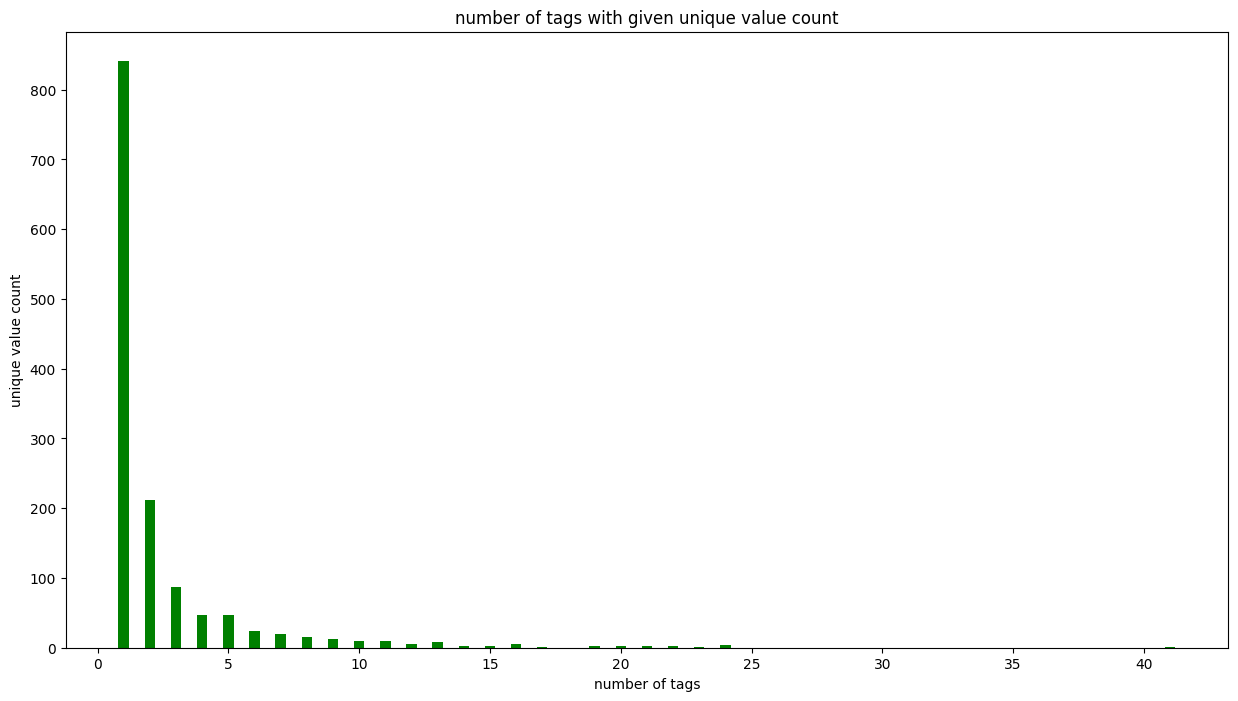

In [ ]:
#plotting number of tags with given unique value count
def tags_visualization_1(tags_df, sortdict):
  unique_tags_dict={}
  for k in sortdict:
    if sortdict[k] in unique_tags_dict:
      unique_tags_dict[sortdict[k]]+=1
    else:
      unique_tags_dict[sortdict[k]]=1
  plt.rcParams["figure.figsize"]=[15,8]
  tags=list(unique_tags_dict.keys())
  values=list(unique_tags_dict.values())
  plt.bar(tags, values, color ="green", width=0.4)
  plt.title("number of tags with given unique value count")
  plt.xlabel("number of tags")
  plt.ylabel("unique value count")

tags_visualization_1(tags_df, sortdict)

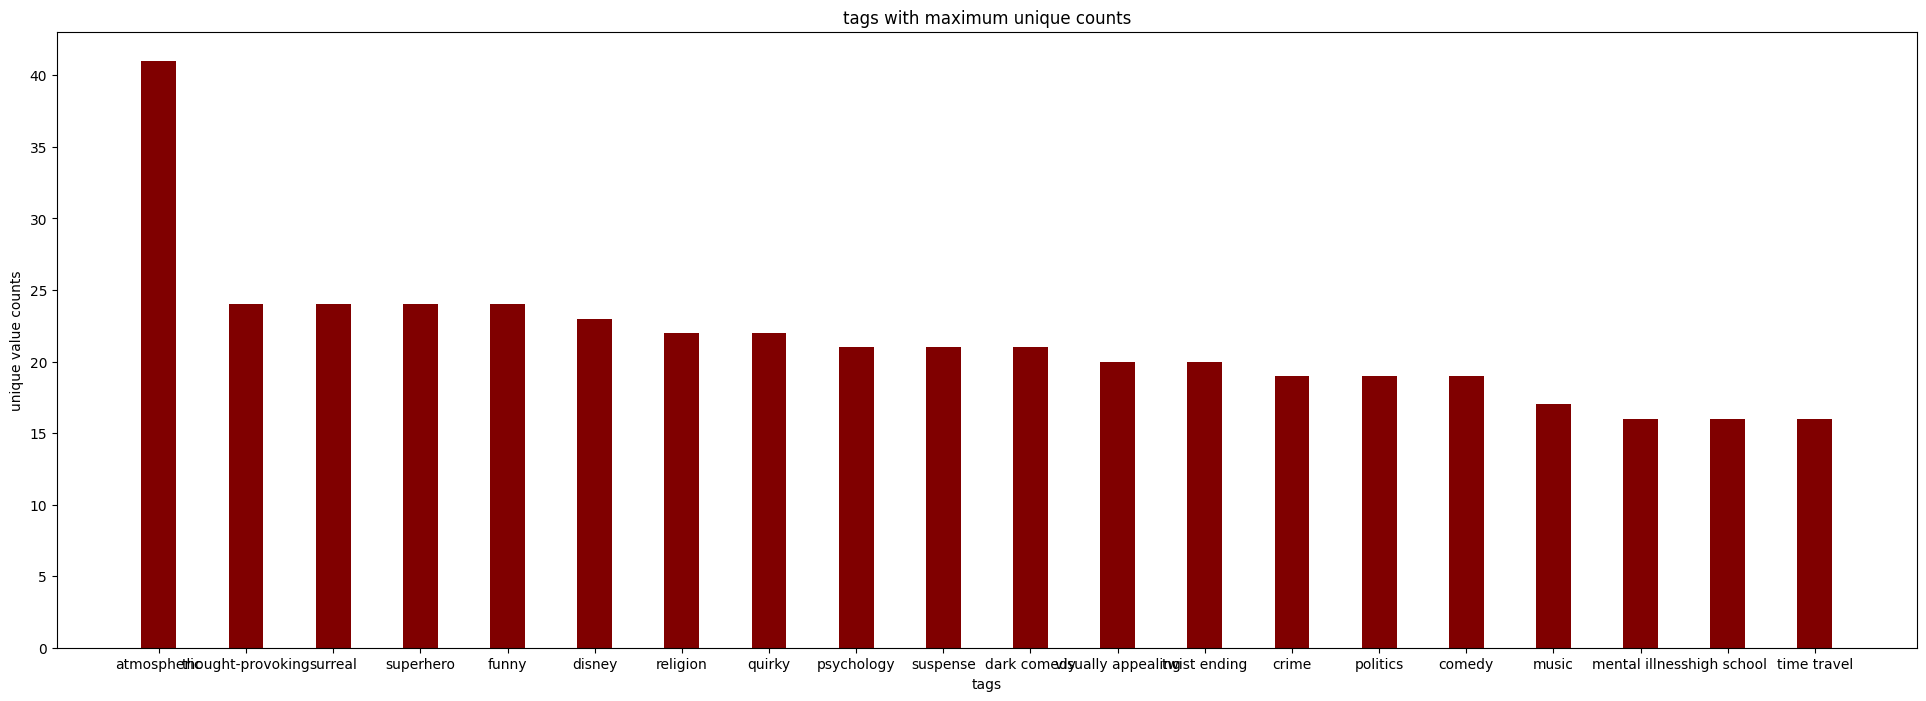

In [ ]:
#plotting the tags with maximum unique counts
def tags_visualization_2(tags_df, sortdict):
  tags=list(sortdict.keys())
  values=list(sortdict.values())
  tags=tags[::-1]
  values=values[::-1]
  tags_new=[]
  values_new=[]

  for i in range(20):
    tags_new.append(tags[i])
    values_new.append(values[i])
  plt.rcParams["figure.figsize"]=[24,8]
  plt.bar(tags_new, values_new, color ='maroon', width=0.4)
  plt.title("tags with maximum unique counts")
  plt.xlabel("tags")
  plt.ylabel("unique value counts")

tags_visualization_2(tags_df, sortdict)

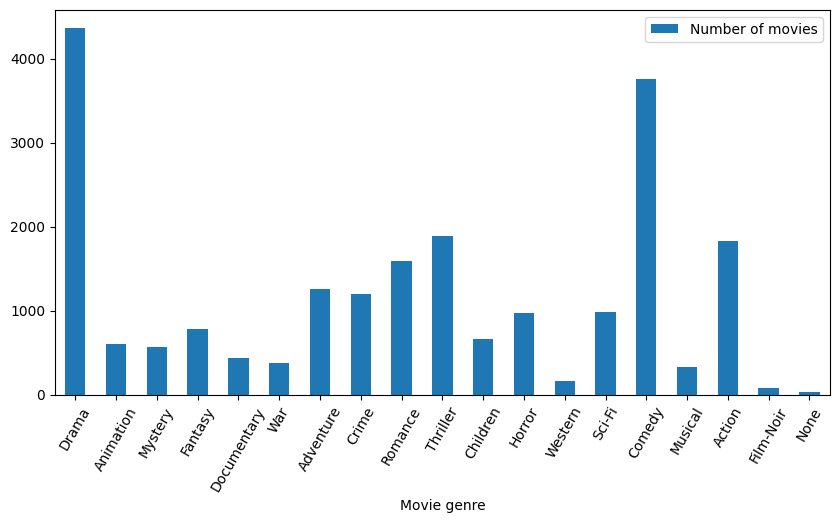

In [ ]:
#identify the unique genres in the dataset
unique_genres=[]
for i in movies.index:
  genres=movies.loc[i,"genres"].split('|')
  unique_genres.extend(genres)
unique_genres=list(set(unique_genres))
unique_genres.remove("(no genres listed)")
unique_genres.remove("IMAX")
unique_genres.append("None")

#make a list of zeroes to store count of each genre
zero_list=np.zeros(9742)
data={
    'movieId' : zero_list,
    'Action' : zero_list,
    'Fantasy' : zero_list,
    'Crime' : zero_list,
    'Documentary' : zero_list,
    'Western' : zero_list,
    'Children' : zero_list,
    'Animation' : zero_list,
    'Adventure' : zero_list,
    'Musical' : zero_list,
    'Sci-Fi' : zero_list,
    'War' : zero_list,
    'Horror' : zero_list,
    'Mystery' : zero_list,
    'Drama' : zero_list,
    'Romance' : zero_list,
    'Thriller' : zero_list,
    'Film-Noir' : zero_list,
    'Comedy' : zero_list,
    'None' : zero_list
}

#form a dataframe that relates movies to genres
genres_df=pd.DataFrame(data)
for i in movies.index:
  genres_df.at[i,"movieId"]=movies.loc[i,"movieId"]
  genres=movies.loc[i,"genres"].split('|')
  for j in range(len(genres)):
    if(genres[j]=="(no genres listed)"):
      genres_df.at[i,"None"]=1
    elif(genres[j]!="IMAX"):
      genres_df.at[i,genres[j]]=1

movie=movies.drop(columns=["genres"])
df1=movie
df1=df1.merge(genres_df,on="movieId",how="right")
items_dataset=df1
dataset=ratings
movie_dataset=items_dataset[['movieId','title']]
merged_dataset=pd.merge(dataset, movie_dataset, how='inner', on='movieId')




count=[]
for i in unique_genres:
  genre_based_movies=items_dataset[['movieId','title',i]]
  genre_based_movies=genre_based_movies[genre_based_movies[i] == 1]
  count.append(len(genre_based_movies))

#plot the data
df=pd.DataFrame({'Movie genre':unique_genres, 'Number of movies':count})
ax=df.plot.bar(x='Movie genre', y='Number of movies', rot=60, figsize=(10, 5))

#Recommendations

##Recommendations using Correlation

In [ ]:
def prediction_using_correlation(movie_name):

  #merge the datasets
  df=ratings
  tags1=tags.drop(columns=['userId','timestamp'])
  df=df.merge(movies,on='movieId',how='left')
  df=df.merge(tags1,on='movieId',how='left')

  #calculate average rating of each movie
  rating=pd.DataFrame(df[['title','rating']].groupby('title')['rating'].mean())

  #claculating the number of people that rated a particular movie
  rating['number of rates']=df.groupby('title')['rating'].count()
  rating=pd.DataFrame(rating)

  #evaluating correlation between user and movie
  movie_user=df.pivot_table(index='userId',columns='title',values='rating')
  correlation=movie_user.corrwith(movie_user[movie_name])
  recommandation=pd.DataFrame(correlation,columns=['correlation']).dropna().join(rating['number of rates'])
  recc=recommandation[recommandation['number of rates']>200].sort_values('correlation',ascending=False).reset_index().merge(movies,on='title',how='left')
  if recc.loc[0,"title"]==movie_name:
    recc=recc.drop(0)

  return recc

In [ ]:
recc=prediction_using_correlation('Star Trek (2009)')

In [ ]:


recc.head(10)


,title,correlation,number of rates,movieId,genres
1,Vertigo (1958),0.868386,300,903,Drama|Mystery|Romance|Thriller
2,Pi (1998),0.818229,799,1921,Drama|Sci-Fi|Thriller
3,"Godfather: Part III, The (1990)",0.778290,225,2023,Crime|Drama|Mystery|Thriller
4,Princess Mononoke (Mononoke-hime) (1997),0.770506,288,3000,Action|Adventure|Animation|Drama|Fantasy
5,(500) Days of Summer (2009),0.745959,336,69757,Comedy|Drama|Romance
6,Burn After Reading (2008),0.733044,429,61323,Comedy|Crime|Drama
7,Big Fish (2003),0.732398,276,7147,Drama|Fantasy|Romance
8,Star Wars: Episode VI - Return of the Jedi (1983),0.698083,588,1210,Action|Adventure|Sci-Fi
9,Howl's Moving Castle (Hauru no ugoku shiro) (2...,0.695863,240,31658,Adventure|Animation|Fantasy|Romance
10,Black Swan (2010),0.686824,252,81591,Drama|Thriller


##Recommendation based on top rated movies that user has not seen

In [ ]:
def recommendation_using_ratings(userid):
  dataset=ratings
  A=dataset.pivot(index="userId", columns='movieId', values='rating')
  A.head()
  A=A.fillna(0)
  A=np.array(A)
  A_df=pd.DataFrame(A)
  user_ratings_mean=np.mean(A, axis=1)
  R_demeaned=A - user_ratings_mean.reshape(-1, 1) #demean the data to centralise and normalise it

  def MatrixFactor(k,learning_rate,num_iter,A):

    nan_cell_mask=np.where(np.isnan(A))
    A[nan_cell_mask]=-1
    U=np.random.rand(np.size(A, 0), k)
    VT=np.random.rand(k, np.size(A, 1))

    loss_list=np.array([])
    for n in range(num_iter):

        for i in range(len(U)):

            # calcualte the squared Frobenius norm
            A_est=np.matmul(U, VT)
            diff_error=np.subtract(A, A_est)
            diff_error[nan_cell_mask]=0
            sq_error=np.square(diff_error)
            sq_error_sum=0.5 * sq_error.sum() # the ignore missing data


            # calculate the gradient for each entry of U
            grad_U=-np.matmul(diff_error, np.transpose(VT))
            # calculate the gradient for each entry of VT
            grad_VT=-np.matmul(np.transpose(U), diff_error)

            # update U and VT
            U= np.subtract(U, learning_rate*grad_U)
            VT=np.subtract(VT, learning_rate*grad_VT)

        loss_list=np.append(loss_list, sq_error_sum)

    return U,VT,loss_list

  U,Vt,sigma=MatrixFactor(24, 0.001, 24, R_demeaned)

  sigma=np.diag(sigma)

  all_user_predicted_ratings=np.dot(np.dot(U, sigma), Vt)
  all_user_predicted_ratings += user_ratings_mean.reshape(-1, 1)

  preds_df=pd.DataFrame(all_user_predicted_ratings, columns=A_df.columns)

  movies_df=movies
  def recommend_movies(predictions_df, userID, movies_df, original_ratings_df):

    num_recommendations=10

    # Get and sort the user's predictions
    user_row_number=userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions=preds_df.iloc[user_row_number].sort_values(ascending=False)

    # Get the user's data and merge in the movie information.
    user_data=original_ratings_df[original_ratings_df.userId == (userID)]
    user_full=(user_data.merge(movies_df, how='left', left_on='movieId', right_on='movieId').sort_values(['rating'], ascending=False))

    print ('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))

    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations=(movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how='left',
               left_on='movieId', right_index=True).
         rename(columns={user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending=False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

  already_rated, predictions=recommend_movies(preds_df, userid, movies_df, dataset)

  return already_rated,predictions

##Recommendation based on Collaborative Filtering using KNN

In [ ]:
def collaborative_knn(movie_name):

  def create_dataset():
    final_dataset=ratings.pivot(index='movieId',columns='userId',values='rating')
    final_dataset=final_dataset.fillna(0)
    no_user_voted=ratings.groupby('movieId')['rating'].agg('count')
    no_movies_voted=ratings.groupby('userId')['rating'].agg('count')
    final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
    csr_data=csr_matrix(final_dataset.values)
    final_dataset.reset_index(inplace=True)

    return csr_data,final_dataset



  def get_movie_recommendation(csr_data,final_dataset):
      knn=NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=15, n_jobs=-1)
      knn.fit(csr_data)
      n_movies_to_reccomend=10
      movie_list=movies[movies['title'].str.contains(movie_name)]
      if len(movie_list):

          movie_idx=movie_list.iloc[0]['movieId']
          movie_idx=final_dataset[final_dataset['movieId'] == movie_idx].index[0]
          distances , indices=knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)
          rec_movie_indices=sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
          recommend_frame=[]
          for val in rec_movie_indices:
              movie_idx=final_dataset.iloc[val[0]]['movieId']
              idx=movies[movies['movieId'] == movie_idx].index
              recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
          df=pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
          return df
      else:
          return "Movie not present in data set"
  movie_name=re.sub('\(.*\)', '', movie_name)
  csr_data,final_dataset=create_dataset()
  return(get_movie_recommendation(csr_data,final_dataset))


In [ ]:
import re
predict_knn=collaborative_knn('Star Trek (2009)')

In [ ]:
predict_knn

,Title,Distance
1,Superman II (1980),0.544326
2,"X-Files: Fight the Future, The (1998)",0.534751
3,Star Trek: Generations (1994),0.495226
4,Star Trek V: The Final Frontier (1989),0.494090
5,Star Trek: Insurrection (1998),0.474105
6,Star Trek: First Contact (1996),0.405153
7,Star Trek II: The Wrath of Khan (1982),0.342706
8,Star Trek: The Motion Picture (1979),0.320083
9,Star Trek III: The Search for Spock (1984),0.287992
10,Star Trek IV: The Voyage Home (1986),0.210878


##Recommendations for a new user

###Splitting on basis of genre

In [ ]:
unique_genres=[]
for i in movies.index:
  genres=movies.loc[i,"genres"].split('|')
  unique_genres.extend(genres)
unique_genres=list(set(unique_genres))
print(unique_genres)
unique_genres.remove("(no genres listed)")
unique_genres.remove("IMAX")
unique_genres.append("None")
print(unique_genres)

['(no genres listed)', 'Drama', 'Animation', 'Mystery', 'Fantasy', 'Documentary', 'War', 'Adventure', 'Crime', 'Romance', 'Thriller', 'Children', 'IMAX', 'Horror', 'Western', 'Sci-Fi', 'Comedy', 'Musical', 'Action', 'Film-Noir']
['Drama', 'Animation', 'Mystery', 'Fantasy', 'Documentary', 'War', 'Adventure', 'Crime', 'Romance', 'Thriller', 'Children', 'Horror', 'Western', 'Sci-Fi', 'Comedy', 'Musical', 'Action', 'Film-Noir', 'None']


In [ ]:
zero_list=np.zeros(9742)
data={
    'movieId' : zero_list,
    'Action' : zero_list,
    'Fantasy' : zero_list,
    'Crime' : zero_list,
    'Documentary' : zero_list,
    'Western' : zero_list,
    'Children' : zero_list,
    'Animation' : zero_list,
    'Adventure' : zero_list,
    'Musical' : zero_list,
    'Sci-Fi' : zero_list,
    'War' : zero_list,
    'Horror' : zero_list,
    'Mystery' : zero_list,
    'Drama' : zero_list,
    'Romance' : zero_list,
    'Thriller' : zero_list,
    'Film-Noir' : zero_list,
    'Comedy' : zero_list,
    'None' : zero_list
}
genres_df=pd.DataFrame(data)
genres_df

,movieId,Action,Fantasy,Crime,Documentary,Western,Children,Animation,Adventure,Musical,Sci-Fi,War,Horror,Mystery,Drama,Romance,Thriller,Film-Noir,Comedy,None
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for i in movies.index:
  genres_df.at[i,"movieId"]=movies.loc[i,"movieId"]
  genres=movies.loc[i,"genres"].split('|')
  for j in range(len(genres)):
    if(genres[j]=="(no genres listed)"):
      genres_df.at[i,"None"]=1
    elif(genres[j]!="IMAX"):
      genres_df.at[i,genres[j]]=1
print(genres_df)

       movieId  Action  Fantasy  Crime  Documentary  Western  Children  Animation  Adventure  Musical  Sci-Fi  War  Horror  Mystery  Drama  Romance  Thriller  Film-Noir  Comedy  None
0          1.0     0.0      1.0    0.0          0.0      0.0       1.0        1.0        1.0      0.0     0.0  0.0     0.0      0.0    0.0      0.0       0.0        0.0     1.0   0.0
1          2.0     0.0      1.0    0.0          0.0      0.0       1.0        0.0        1.0      0.0     0.0  0.0     0.0      0.0    0.0      0.0       0.0        0.0     0.0   0.0
2          3.0     0.0      0.0    0.0          0.0      0.0       0.0        0.0        0.0      0.0     0.0  0.0     0.0      0.0    0.0      1.0       0.0        0.0     1.0   0.0
3          4.0     0.0      0.0    0.0          0.0      0.0       0.0        0.0        0.0      0.0     0.0  0.0     0.0      0.0    1.0      1.0       0.0        0.0     1.0   0.0
4          5.0     0.0      0.0    0.0          0.0      0.0       0.0        0.0    

###Creating a merged dataset

In [ ]:
movie=movies.drop(columns=["genres"])
movie

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [ ]:
df1=movie
df=df1
df1

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [ ]:
df1=df1.merge(genres_df,on="movieId",how="right")
df1

,movieId,title,Action,Fantasy,Crime,Documentary,Western,Children,Animation,Adventure,...,Sci-Fi,War,Horror,Mystery,Drama,Romance,Thriller,Film-Noir,Comedy,None
0,1,Toy Story (1995),0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,Jumanji (1995),0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9738,193583,No Game No Life: Zero (2017),0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9739,193585,Flint (2017),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
items_dataset=df1
dataset=ratings
movie_dataset=items_dataset[['movieId','title']]
movie_dataset.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
merged_dataset=pd.merge(dataset, movie_dataset, how='inner', on='movieId')
merged_dataset.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


###Recommendation based on top average rating

In [ ]:
#obtain movies with top average rating
def top_avg_rating():
  avg_highly_rated_movies=merged_dataset.groupby(['title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
  avg_highly_rated_movies=avg_highly_rated_movies.reset_index(level=0)
  avg_highly_rated_movies.columns=['title', 'avg rating']

  return avg_highly_rated_movies

In [ ]:
avg_highly_rated=top_avg_rating()
avg_highly_rated.head(10)

,title,avg rating
0,Gena the Crocodile (1969),5.0
1,True Stories (1986),5.0
2,Cosmic Scrat-tastrophe (2015),5.0
3,Love and Pigeons (1985),5.0
4,Red Sorghum (Hong gao liang) (1987),5.0
5,"Thin Line Between Love and Hate, A (1996)",5.0
6,Lesson Faust (1994),5.0
7,Eva (2011),5.0
8,Who Killed Chea Vichea? (2010),5.0
9,Siam Sunset (1999),5.0


###Recommendation based on popularity

In [ ]:
#obtain most watched movies
def most_popular():
  merged_dataset.groupby(['title']).agg({"rating":"sum"})['rating'].sort_values(ascending=False)
  popular_movies=merged_dataset.groupby(['title']).agg({"rating":"count"})['rating'].sort_values(ascending=False)
  popular_movies=pd.DataFrame(popular_movies)
  popular_movies.reset_index(level=0, inplace=True)
  popular_movies.columns=['title', 'Number of Users watched']

  return popular_movies

In [ ]:
popular_movies=most_popular()
popular_movies.head(10)

,title,Number of Users watched
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
5,Star Wars: Episode IV - A New Hope (1977),251
6,Jurassic Park (1993),238
7,Braveheart (1995),237
8,Terminator 2: Judgment Day (1991),224
9,Schindler's List (1993),220


###Recommendation based on ratings and popularity

In [ ]:
highly_rated_popular_movies=pd.merge(avg_highly_rated, popular_movies, how='inner', on='title')

In [ ]:
highly_rated_popular_movies[(highly_rated_popular_movies['Number of Users watched']>200) & (highly_rated_popular_movies['avg rating']>=4.0)]

,title,avg rating,Number of Users watched
722,"Shawshank Redemption, The (1994)",4.429022,317
808,Fight Club (1999),4.272936,218
933,"Usual Suspects, The (1995)",4.237745,204
935,Star Wars: Episode IV - A New Hope (1977),4.231076,251
940,Schindler's List (1993),4.225000,220
949,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211
971,Pulp Fiction (1994),4.197068,307
972,"Matrix, The (1999)",4.192446,278
1035,Forrest Gump (1994),4.164134,329
1038,"Silence of the Lambs, The (1991)",4.161290,279


###Recommending the top movies of every genre

In [ ]:
def recommendations_genre(genre):
  x=genre
  print("GENRE:", x)
  genre_based_movies=items_dataset[['movieId','title',x]]
  genre_based_movies=genre_based_movies[genre_based_movies[x] == 1]
  merged_genre_movies=pd.merge(dataset, genre_based_movies, how='inner', on='movieId')
  popular_movies_ingenre=merged_genre_movies.groupby(['title']).agg({"rating":"count"})['rating'].sort_values(ascending=False)
  popular_movies_ingenre=popular_movies_ingenre.to_frame()
  popular_movies_ingenre.reset_index(level=0, inplace=True)
  popular_movies_ingenre.columns=['title', 'Number of Users watched']

  high_rated_movies=merged_genre_movies.groupby(['title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
  high_rated_movies=high_rated_movies.to_frame()
  highly_rated_popular_movies=pd.merge(high_rated_movies, popular_movies_ingenre, how='inner', on='title')
  viewer_limit=300
  ratings_limit=4.0
  count=0
  check=0
  while viewer_limit > 0 and ratings_limit > 0:
    s=highly_rated_popular_movies[(highly_rated_popular_movies['Number of Users watched']>viewer_limit) & (highly_rated_popular_movies['rating']>=ratings_limit)]
    if len(s) < 13:
      if check == 0:
        viewer_limit -= 50
        check=1
      else:
        ratings_limit -= 0.5
        check=0
    else:
      break


  print(s[['title','rating']])
  print()


In [ ]:
def make_user_rating_dataset():
  # creating dataframe based on user id

  zero_list=np.zeros(610)
  useridlist=[]
  for i in range(1,611):
    useridlist.append(i)
    data={
        'userId' : useridlist,
        'Action' : zero_list,
        'Fantasy' : zero_list,
        'Crime' : zero_list,
        'Documentary' : zero_list,
        'Western' : zero_list,
        'Children' : zero_list,
        'Animation' : zero_list,
        'Adventure' : zero_list,
        'Musical' : zero_list,
        'Sci-Fi' : zero_list,
        'War' : zero_list,
        'Horror' : zero_list,
        'Mystery' : zero_list,
        'Drama' : zero_list,
        'Romance' : zero_list,
        'Thriller' : zero_list,
        'Film-Noir' : zero_list,
        'Comedy' : zero_list,
        'None' : zero_list
    }
  user_ratings_df=pd.DataFrame(data)
  user_ratings_df #construct an empty dataset

  total_ratings=np.zeros(610)
  k=0
  for i in ratings.index:
    userid=ratings.loc[i,"userId"]
    movieid=ratings.loc[i,"movieId"]
    idx=movies.index[movies["movieId"]==movieid].values
    idx=int(idx)
    genres_list=movies.loc[idx,"genres"].split('|') #make list of all the genres in a movie
    for j in range(len(genres_list)):
      if(genres_list[j]=="(no genres listed)"): #since we have changed "(no genres listed)" to "None".
        user_ratings_df.at[userid-1,"None"]+=ratings.loc[i,"rating"]
      elif(genres_list[j]!="IMAX"): #since "IMAX" is not a genre and we removed it earlier
        user_ratings_df.at[userid-1,genres_list[j]]+=ratings.loc[i,"rating"]
      total_ratings[userid-1]+=ratings.loc[i,"rating"] #total ratings given by a user for all the genres

  k=0
  cols=['Comedy', 'Drama', 'Mystery', 'Horror', 'Action', 'Documentary', 'Film-Noir', 'Thriller', 'Fantasy', 'Adventure', 'Western', 'Crime', 'Children', 'Romance', 'Sci-Fi', 'Musical', 'War', 'Animation', 'None']
  for i in user_ratings_df.index: #divide the cell values woth total rating given by each user to obtain mean values
    for col in cols:
      user_ratings_df.at[i,col]/=total_ratings[k]
    k+=1

  return(user_ratings_df) #return the dataset

user_ratings_df=make_user_rating_dataset()

Pipelines

In [ ]:
def pipeline(str):
  if(str=='New'):
    print('Top movies based on ratings and popularity are:')
    print(highly_rated_popular_movies[(highly_rated_popular_movies['Number of Users watched']>200) & (highly_rated_popular_movies['avg rating']>=4.0)][['title','avg rating']])
    print()


    print('Most popular movies of every genre are:')
    for i in unique_genres:
      recommendations_genre(i)

  else:
    userid=int(input('Please Enter User Id:'))
    movie_ip=input('Please enter a movie you have watched and that you like:')

    print()
    print('Recommendations using Correlation based on movie liked by user:')
    recc=prediction_using_correlation(movie_ip)
    print(recc[['title','genres']].head(10))
    print()

    print('Recommendations using Stochastic Gradient Descent based on movies the user has not watched:')
    already_rated,predictions=recommendation_using_ratings(userid)
    print(predictions.head(10))
    print()

    print("Recommendations using Collaborative Filtering and KNN based on the movie liked by the user:")
    predict_knn=collaborative_knn(movie_ip)
    print(predict_knn['Title'].head(10))
    print()

    # print("Recommendations using Deep Learning Models based on the movie liked by the user as well as the top ratings:")
    # predict_based_on_user_id(userid)
    # print()

In [ ]:
user_type=input('Please enter New if you are a new user and Old if you are a returning user:')
pipeline(user_type)

Please enter New if you are a new user and Old if you are a returning user:New
Top movies based on ratings and popularity are:
                                                  title  avg rating
722                    Shawshank Redemption, The (1994)    4.429022
808                                   Fight Club (1999)    4.272936
933                          Usual Suspects, The (1995)    4.237745
935           Star Wars: Episode IV - A New Hope (1977)    4.231076
940                             Schindler's List (1993)    4.225000
949   Star Wars: Episode V - The Empire Strikes Back...    4.215640
971                                 Pulp Fiction (1994)    4.197068
972                                  Matrix, The (1999)    4.192446
1035                                Forrest Gump (1994)    4.164134
1038                   Silence of the Lambs, The (1991)    4.161290
1192                             American Beauty (1999)    4.056373
1233                                  Braveheart (1995)  